In [43]:
import os
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [44]:
from botorch.test_functions import Hartmann

neg_hartmann6 = Hartmann(negate=True)

def outcome_constraint(X):
    """L1 constraint; feasible if less than or equal to zero."""
    return X.sum(dim=-1) - 3

def weighted_obj(X):
    """Feasibility weighted objective; zero if not feasible."""
    return neg_hartmann6(X) * (outcome_constraint(X) <= 0).type_as(X)

In [45]:
from botorch.models import FixedNoiseGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

In [46]:
NOISE_SE = 0.5
train_yvar = torch.tensor(NOISE_SE**2, device=device, dtype=dtype)

In [47]:
def generate_initial_data(n=10):
    # generate training data
    train_x = torch.rand(10, 6, device=device, dtype=dtype)
    exact_obj = neg_hartmann6(train_x).unsqueeze(-1)  # add output dimension
    # print(exact_obj.shape)
    exact_con = outcome_constraint(train_x).unsqueeze(-1)  # add output dimension
    
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    train_con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    best_observed_value = weighted_obj(train_x).max().item()
    return train_x, train_obj, train_con, best_observed_value

In [48]:
def initialize_model(train_x, train_obj, train_con, state_dict=None):
    # define models for objective and constraint
    model_obj = FixedNoiseGP(train_x, train_obj, train_yvar.expand_as(train_obj)).to(
        train_x
    )
    model_con = FixedNoiseGP(train_x, train_con, train_yvar.expand_as(train_con)).to(
        train_x
    )
    # combine into a multi-output GP model
    model = ModelListGP(model_obj, model_con)
    # model = model_obj
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

In [49]:
from botorch.acquisition.objective import ConstrainedMCObjective


def obj_callable(Z):
    print(Z.shape)
    print(Z[..., 0].shape)
    return Z[..., 0]


def constraint_callable(Z):
    return Z[..., 1]


# define a feasibility-weighted objective for optimization
constrained_obj = ConstrainedMCObjective(
    objective=obj_callable,
    constraints=[constraint_callable],
)

In [50]:
from botorch.optim import optimize_acqf

bounds = torch.tensor([[0.0] * 6, [1.0] * 6], device=device, dtype=dtype)

In [51]:
BATCH_SIZE = 3 if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32

In [52]:
def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # print(candidates.shape)
    # observe new values
    new_x = candidates.detach()
    exact_obj = neg_hartmann6(new_x).unsqueeze(-1)  # add output dimension
    exact_con = outcome_constraint(new_x).unsqueeze(-1)  # add output dimension
    new_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    new_con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    return new_x, new_obj, new_con


In [53]:
def update_random_observations(best_random):
    """Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = torch.rand(BATCH_SIZE, 6)
    next_random_best = weighted_obj(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))
    return best_random

In [54]:
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
)
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning

In [55]:
import time
import warnings

In [56]:
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [57]:
N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 20 if not SMOKE_TEST else 2
MC_SAMPLES = 256 if not SMOKE_TEST else 32

verbose = False

best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []

In [58]:
(
    train_x_ei,
    train_obj_ei,
    train_con_ei,
    best_observed_value_ei,
) = generate_initial_data(n=10)

In [59]:
train_x_ei.shape, train_obj_ei.shape

(torch.Size([10, 6]), torch.Size([10, 1]))

In [60]:
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
)
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning

import time
import warnings


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 20 if not SMOKE_TEST else 2
MC_SAMPLES = 256 if not SMOKE_TEST else 32

verbose = False

best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []


# average over multiple trials
# for trial in range(1, N_TRIALS + 1):
for trial in range(1, 2):

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei, best_observed_nei, best_random = [], [], []

    # call helper functions to generate initial training data and initialize model
    (
        train_x_ei,
        train_obj_ei,
        train_con_ei,
        best_observed_value_ei,
    ) = generate_initial_data(n=10)
    mll_ei, model_ei = initialize_model(train_x_ei, train_obj_ei, train_con_ei)

    train_x_nei, train_obj_nei, train_con_nei = train_x_ei, train_obj_ei, train_con_ei
    best_observed_value_nei = best_observed_value_ei
    mll_nei, model_nei = initialize_model(train_x_nei, train_obj_nei, train_con_nei)

    best_observed_ei.append(best_observed_value_ei)
    best_observed_nei.append(best_observed_value_nei)
    best_random.append(best_observed_value_ei)

    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):

        t0 = time.monotonic()

        # fit the models
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_nei)

        # define the qEI and qNEI acquisition modules using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

        # for best_f, we use the best observed noisy values as an approximation
        qEI = qExpectedImprovement(
            model=model_ei,
            best_f=(train_obj_ei * (train_con_ei <= 0).to(train_obj_ei)).max(),
            sampler=qmc_sampler,
            objective=constrained_obj,
        )

        qNEI = qNoisyExpectedImprovement(
            model=model_nei,
            X_baseline=train_x_nei,
            sampler=qmc_sampler,
            objective=constrained_obj,
        )

        # optimize and get new observation
        new_x_ei, new_obj_ei, new_con_ei = optimize_acqf_and_get_observation(qEI)
        new_x_nei, new_obj_nei, new_con_nei = optimize_acqf_and_get_observation(qNEI)

        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])
        train_con_ei = torch.cat([train_con_ei, new_con_ei])

        train_x_nei = torch.cat([train_x_nei, new_x_nei])
        train_obj_nei = torch.cat([train_obj_nei, new_obj_nei])
        train_con_nei = torch.cat([train_con_nei, new_con_nei])

        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = weighted_obj(train_x_ei).max().item()
        best_value_nei = weighted_obj(train_x_nei).max().item()
        best_observed_ei.append(best_value_ei)
        best_observed_nei.append(best_value_nei)

        # reinitialize the models so they are ready for fitting on next iteration
        # use the current state dict to speed up fitting
        mll_ei, model_ei = initialize_model(
            train_x_ei,
            train_obj_ei,
            train_con_ei,
            model_ei.state_dict(),
        )
        mll_nei, model_nei = initialize_model(
            train_x_nei,
            train_obj_nei,
            train_con_nei,
            model_nei.state_dict(),
        )

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI, qNEI) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}, {best_value_nei:>4.2f}), "
                f"time = {t1-t0:>4.2f}.",
                end="",
            )
        else:
            print(".", end="")

    best_observed_all_ei.append(best_observed_ei)
    best_observed_all_nei.append(best_observed_nei)
    best_random_all.append(best_random)


Trial  1 of 3 torch.Size([2048, 10, 2])
torch.Size([2048, 10])
torch.Size([256, 10, 2])
torch.Size([256, 10])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3,

/Users/liuqianyi/miniconda3/envs/r244/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0271], dtype=torch.float64), std = tensor([0.5022], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/liuqianyi/miniconda3/envs/r244/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0870], dtype=torch.float64), std = tensor([0.6094], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torc

/Users/liuqianyi/miniconda3/envs/r244/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0847], dtype=torch.float64), std = tensor([0.4915], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/liuqianyi/miniconda3/envs/r244/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0219], dtype=torch.float64), std = tensor([0.7249], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/liuqianyi/miniconda3/envs/r244/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0154], dtype=torch.float64), std = tensor([0.4606], dtype=torch.float64)). Please consider scaling the input to zero mean a

torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torch.Size([256, 5, 3])
torch.Size([256, 5, 3, 2])
torc

KeyboardInterrupt: 

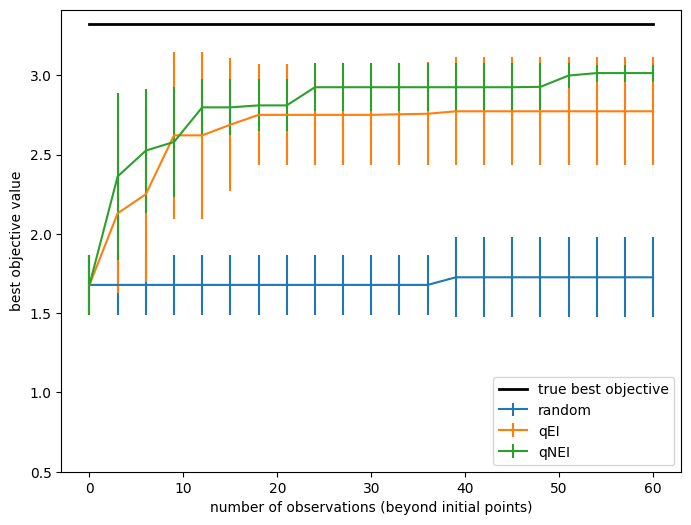

In [83]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


GLOBAL_MAXIMUM = neg_hartmann6.optimal_value


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
y_ei = np.asarray(best_observed_all_ei)
y_nei = np.asarray(best_observed_all_nei)
y_rnd = np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5)
ax.errorbar(iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="qEI", linewidth=1.5)
ax.errorbar(iters, y_nei.mean(axis=0), yerr=ci(y_nei), label="qNEI", linewidth=1.5)
plt.plot(
    [0, N_BATCH * BATCH_SIZE],
    [GLOBAL_MAXIMUM] * 2,
    "k",
    label="true best objective",
    linewidth=2,
)
ax.set_ylim(bottom=0.5)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="best objective value",
)
ax.legend(loc="lower right")

In [86]:
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

In [87]:
kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)

In [93]:
kernel.bounds

array([[-11.51292546,  11.51292546],
       [-11.51292546,  11.51292546]])

In [94]:
kernel.hyperparameters

[Hyperparameter(name='k1__constant_value', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False)]

In [96]:
kernel.theta

array([0., 0.])

In [173]:
x = np.random.rand(3, 2)
y = np.random.rand(3, 2)

In [174]:
kernel(x, y)

array([[0.51751039, 0.78958343, 0.93673039],
       [0.84061437, 0.99824797, 0.86561325],
       [0.94850256, 0.8985198 , 0.79272738]])

In [185]:
from gpytorch.kernels import MaternKernel
from gpytorch.constraints import Interval
kernel_2 = MaternKernel(nu=2.5, lengthscale_constraint=Interval(1e-5, 1e5))
kernel_2.lengthscale = 1.0

In [187]:
kernel_2.has_lengthscale

True

In [186]:
kernel_2.lengthscale

tensor([[1.0000]], grad_fn=<AddBackward0>)

In [177]:
x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

In [178]:
kernel_2(x_tensor, y_tensor).to_dense()

tensor([[0.5175, 0.7896, 0.9367],
        [0.8406, 0.9982, 0.8656],
        [0.9485, 0.8985, 0.7927]], dtype=torch.float64,
       grad_fn=<MaternCovarianceBackward>)

In [179]:
from sklearn.datasets import load_iris
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern
X, y = load_iris(return_X_y=True)

In [180]:
X.shape, y.shape

((150, 4), (150,))